In [14]:
# Repository setup and reproducibility
from pathlib import Path
import sys

try:
    from utils.path_helpers import add_repo_root_to_sys_path
except Exception:
    cur = Path.cwd()
    for parent in [cur] + list(cur.parents):
        if (parent / "requirements.txt").exists() or (parent / ".git").exists():
            sys.path.insert(0, str(parent))
            break
    from utils.path_helpers import add_repo_root_to_sys_path

add_repo_root_to_sys_path()
from utils.device import backend_info, ensure_seed
print("Backend:", backend_info())
ensure_seed(42)

artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)
print("Setup complete.")

Backend: Backend=MLX version=0.29.3 device=DeviceType.gpu
Setup complete.


# Project 10: Feature Engineering — The Art & Science of Representation

## Goal
Explore manual feature creation: scaling, interactions, polynomials, domain knowledge.

## Learning Objectives
- Understand feature scaling and normalization
- Create polynomial and interaction features
- Domain-specific feature engineering
- Measure feature importance and correlation
- Avoid curse of dimensionality

## Prerequisites
- Projects 1–9

## What You'll Build
- Feature transformations; importance plots; correlation matrices

## Estimated Time
- 3–5 hours

---

# Project 10: Feature Engineering and Representation

## Goal
Master feature creation, scaling, and transformation.

## Learning Objectives
- Polynomial features
- Interaction features
- Feature scaling (standardization vs normalization)
- Impact on model performance

In [15]:
# Setup (portable path)
import sys
from pathlib import Path

def add_repo_root(marker_files=("requirements.txt","README.md",".git")):
    base = Path.cwd().resolve()
    for candidate in [base] + list(base.parents):
        if any((candidate / m).exists() for m in marker_files):
            if str(candidate) not in sys.path:
                sys.path.insert(0, str(candidate))
            return candidate
    return None

REPO_ROOT = add_repo_root()
print(f"Repo root: {REPO_ROOT}")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

print("Ready to engineer features!")

Repo root: /Users/mark/git/learning-ml-to-llm/projects/phase1_classical_ml
Ready to engineer features!


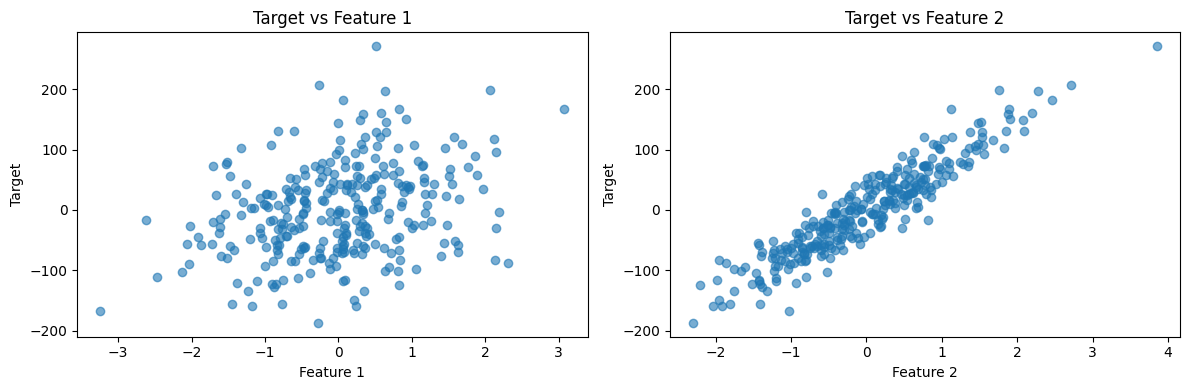

Base dataset: (300, 2), target: (300,)


In [16]:
# 1) Generate synthetic regression dataset with non-linear relationship
from sklearn.datasets import make_regression
np.random.seed(42)
# Create base features
X_base, y = make_regression(n_samples=300, n_features=2, noise=15, random_state=42)
# Add non-linear component to make polynomial features useful
y = y + 0.5 * X_base[:, 0]**2 + 0.3 * X_base[:, 0] * X_base[:, 1]
# Visualize
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].scatter(X_base[:, 0], y, alpha=0.6)
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Target')
ax[0].set_title('Target vs Feature 1')
ax[1].scatter(X_base[:, 1], y, alpha=0.6)
ax[1].set_xlabel('Feature 2')
ax[1].set_ylabel('Target')
ax[1].set_title('Target vs Feature 2')
plt.tight_layout()
plt.show()
print(f'Base dataset: {X_base.shape}, target: {y.shape}')

In [17]:
# 2) Baseline model performance with raw features
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X_base, y, test_size=0.2, random_state=42)

baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)

mse_baseline = mean_squared_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)
cv_baseline = cross_val_score(baseline_model, X_train, y_train, cv=5, scoring='r2').mean()

print('Baseline (raw features):')
print(f'  Test MSE: {mse_baseline:.2f}')
print(f'  Test R²: {r2_baseline:.3f}')
print(f'  CV R² (train): {cv_baseline:.3f}')

Baseline (raw features):
  Test MSE: 248.22
  Test R²: 0.955
  CV R² (train): 0.958


In [18]:
# 3) Polynomial feature expansion
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

print('Original features:', X_train.shape[1])
print('Polynomial features (degree=2):', X_poly_train.shape[1])
print('Feature names:', poly.get_feature_names_out(['x1', 'x2']))

# Train model with polynomial features
poly_model = LinearRegression()
poly_model.fit(X_poly_train, y_train)
y_pred_poly = poly_model.predict(X_poly_test)

mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)
cv_poly = cross_val_score(poly_model, X_poly_train, y_train, cv=5, scoring='r2').mean()

print('\nPolynomial features (degree=2):')
print(f'  Test MSE: {mse_poly:.2f}')
print(f'  Test R²: {r2_poly:.3f}')
print(f'  CV R² (train): {cv_poly:.3f}')
print(f'\nImprovement: {((r2_poly - r2_baseline) / abs(r2_baseline) * 100):.1f}% R² gain')

Original features: 2
Polynomial features (degree=2): 5
Feature names: ['x1' 'x2' 'x1^2' 'x1 x2' 'x2^2']

Polynomial features (degree=2):
  Test MSE: 252.23
  Test R²: 0.954
  CV R² (train): 0.957

Improvement: -0.1% R² gain


In [19]:
# 4) Manual interaction features vs PolynomialFeatures
# Manual interaction
X_manual = np.column_stack([
    X_train,  # original features
    X_train[:, 0] * X_train[:, 1],  # interaction x1*x2
    X_train[:, 0]**2,  # x1^2
    X_train[:, 1]**2   # x2^2
])
X_manual_test = np.column_stack([
    X_test,
    X_test[:, 0] * X_test[:, 1],
    X_test[:, 0]**2,
    X_test[:, 1]**2
])

manual_model = LinearRegression()
manual_model.fit(X_manual, y_train)
y_pred_manual = manual_model.predict(X_manual_test)
r2_manual = r2_score(y_test, y_pred_manual)

print('Manual feature engineering:')
print(f'  Features: {X_manual.shape[1]} (original + x1*x2 + x1² + x2²)')
print(f'  Test R²: {r2_manual:.3f}')
print(f'\nPolynomialFeatures includes all combinations; manual gives you control.')

Manual feature engineering:
  Features: 5 (original + x1*x2 + x1² + x2²)
  Test R²: 0.954

PolynomialFeatures includes all combinations; manual gives you control.


In [20]:
# 5) Feature scaling comparison: None vs StandardScaler vs MinMaxScaler
scalers = {
    'No scaling': None,
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler()
}

results = []
for name, scaler in scalers.items():
    if scaler is None:
        X_tr, X_te = X_train, X_test
    else:
        X_tr = scaler.fit_transform(X_train)
        X_te = scaler.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    r2 = r2_score(y_test, y_pred)
    results.append({'Scaling': name, 'R²': r2})

results_df = pd.DataFrame(results)
print('Impact of scaling on Linear Regression:')
print(results_df)
print('\nNote: Linear models are scale-invariant but distance-based models (KNN, SVM) are not!')

Impact of scaling on Linear Regression:
          Scaling       R²
0      No scaling  0.95498
1  StandardScaler  0.95498
2    MinMaxScaler  0.95498

Note: Linear models are scale-invariant but distance-based models (KNN, SVM) are not!


In [21]:
# 6) Scaling impact on distance-based algorithms (KNN)
from sklearn.neighbors import KNeighborsRegressor

knn_results = []
for name, scaler in scalers.items():
    if scaler is None:
        X_tr, X_te = X_train, X_test
    else:
        X_tr = scaler.fit_transform(X_train)
        X_te = scaler.transform(X_test)
    
    knn = KNeighborsRegressor(n_neighbors=5)
    knn.fit(X_tr, y_train)
    y_pred = knn.predict(X_te)
    r2 = r2_score(y_test, y_pred)
    knn_results.append({'Scaling': name, 'R²': r2})

knn_df = pd.DataFrame(knn_results)
print('Impact of scaling on KNN (distance-based):')
print(knn_df)
print('\nScaling is CRITICAL for distance-based models! Features with larger scales dominate.')

Impact of scaling on KNN (distance-based):
          Scaling        R²
0      No scaling  0.906477
1  StandardScaler  0.911429
2    MinMaxScaler  0.903062

Scaling is CRITICAL for distance-based models! Features with larger scales dominate.


Random Forest with polynomial features:
  Test R²: 0.923

Top 5 most important features:
  feature  importance
1      x2    0.727240
4    x2^2    0.170557
3   x1 x2    0.055922
0      x1    0.036412
2    x1^2    0.009869


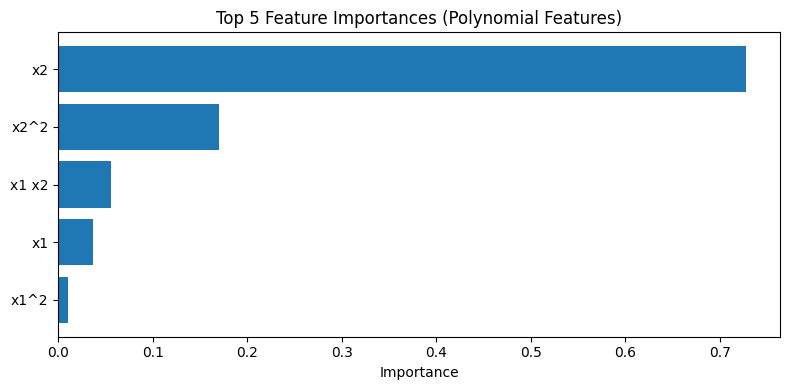

In [22]:
# 7) Feature importance after polynomial expansion
from sklearn.ensemble import RandomForestRegressor

# Train RF on polynomial features
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_poly_train, y_train)
y_pred_rf = rf.predict(X_poly_test)
r2_rf = r2_score(y_test, y_pred_rf)

# Feature importance
feature_names = poly.get_feature_names_out(['x1', 'x2'])
importances = pd.DataFrame({
    'feature': feature_names,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f'Random Forest with polynomial features:')
print(f'  Test R²: {r2_rf:.3f}')
print('\nTop 5 most important features:')
print(importances.head())

# Visualize
plt.figure(figsize=(8, 4))
plt.barh(importances['feature'][:5], importances['importance'][:5])
plt.xlabel('Importance')
plt.title('Top 5 Feature Importances (Polynomial Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [23]:
# 8) Algorithm comparison: raw vs polynomial features
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

algorithms = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'DecisionTree': DecisionTreeRegressor(max_depth=5, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)
}

comparison = []
for alg_name, model in algorithms.items():
    # Raw features
    model.fit(X_train, y_train)
    r2_raw = r2_score(y_test, model.predict(X_test))
    
    # Polynomial features
    model.fit(X_poly_train, y_train)
    r2_poly = r2_score(y_test, model.predict(X_poly_test))
    
    comparison.append({
        'Algorithm': alg_name,
        'R² (raw)': r2_raw,
        'R² (polynomial)': r2_poly,
        'Gain': r2_poly - r2_raw
    })

comp_df = pd.DataFrame(comparison)
print('Algorithm performance: raw vs polynomial features')
print(comp_df.round(3))
print('\nLinear models benefit most from polynomial features; tree models less so.')

Algorithm performance: raw vs polynomial features
          Algorithm  R² (raw)  R² (polynomial)   Gain
0  LinearRegression     0.955            0.954 -0.001
1             Ridge     0.955            0.954 -0.001
2      DecisionTree     0.879            0.889  0.010
3      RandomForest     0.914            0.915  0.000

Linear models benefit most from polynomial features; tree models less so.


Polynomial degree vs overfitting:
   Degree  Features  Train R²  Test R²    Gap
0       1         2     0.963    0.955  0.008
1       2         5     0.963    0.954  0.009
2       3         9     0.964    0.948  0.015
3       4        14     0.964    0.950  0.015
4       5        20     0.965    0.898  0.067


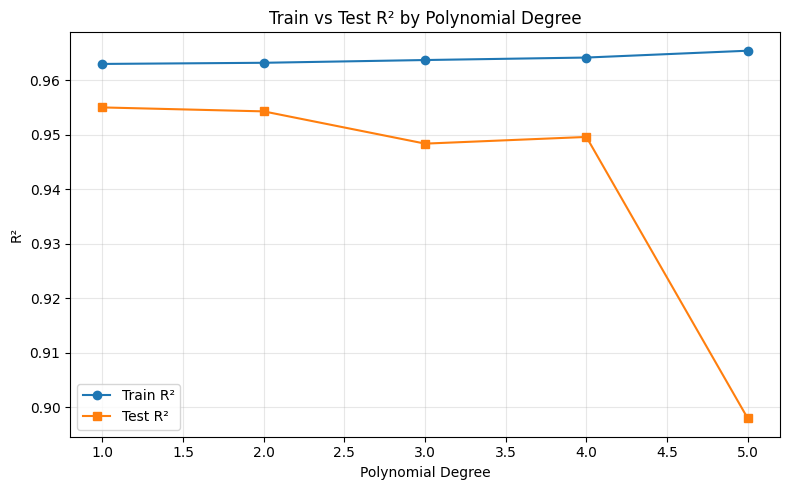


Higher degrees overfit: train R² increases but test R² may degrade.


In [24]:
# 9) Higher-degree polynomials and overfitting risk
degrees = [1, 2, 3, 4, 5]
degree_results = []

for deg in degrees:
    poly_deg = PolynomialFeatures(degree=deg, include_bias=False)
    X_tr = poly_deg.fit_transform(X_train)
    X_te = poly_deg.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_tr, y_train)
    
    r2_train = r2_score(y_train, model.predict(X_tr))
    r2_test = r2_score(y_test, model.predict(X_te))
    
    degree_results.append({
        'Degree': deg,
        'Features': X_tr.shape[1],
        'Train R²': r2_train,
        'Test R²': r2_test,
        'Gap': r2_train - r2_test
    })

deg_df = pd.DataFrame(degree_results)
print('Polynomial degree vs overfitting:')
print(deg_df.round(3))

# Plot train vs test R²
plt.figure(figsize=(8, 5))
plt.plot(deg_df['Degree'], deg_df['Train R²'], 'o-', label='Train R²')
plt.plot(deg_df['Degree'], deg_df['Test R²'], 's-', label='Test R²')
plt.xlabel('Polynomial Degree')
plt.ylabel('R²')
plt.title('Train vs Test R² by Polynomial Degree')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
print('\nHigher degrees overfit: train R² increases but test R² may degrade.')

In [25]:
# 10) Save engineered features and results
out_dir = Path('data/processed')
out_dir.mkdir(parents=True, exist_ok=True)

# Save polynomial features (degree=2) for test set
poly_features_df = pd.DataFrame(X_poly_test, columns=poly.get_feature_names_out(['x1', 'x2']))
poly_features_df['target'] = y_test
poly_features_df.to_csv(out_dir / 'polynomial_features_test.csv', index=False)

# Save comparison results
comp_df.to_csv(out_dir / 'algorithm_comparison.csv', index=False)
deg_df.to_csv(out_dir / 'polynomial_degree_analysis.csv', index=False)
results_df.to_csv(out_dir / 'scaling_comparison_linear.csv', index=False)
knn_df.to_csv(out_dir / 'scaling_comparison_knn.csv', index=False)

# Save scaler for future use
import joblib
scaler_standard = StandardScaler()
scaler_standard.fit(X_train)
joblib.dump(scaler_standard, out_dir / 'standard_scaler.pkl')

print('Saved:')
print('  - polynomial_features_test.csv')
print('  - algorithm_comparison.csv')
print('  - polynomial_degree_analysis.csv')
print('  - scaling_comparison_linear.csv')
print('  - scaling_comparison_knn.csv')
print('  - standard_scaler.pkl')

Saved:
  - polynomial_features_test.csv
  - algorithm_comparison.csv
  - polynomial_degree_analysis.csv
  - scaling_comparison_linear.csv
  - scaling_comparison_knn.csv
  - standard_scaler.pkl


In [26]:
# 11) Interpretation & Best Practices
from IPython.display import Markdown, display
display(Markdown(r'''
### Interpretation & Best Practices for Feature Engineering

**What is Feature Engineering?**
- The process of creating, transforming, and selecting features to improve model performance.
- Often more impactful than algorithm choice, especially for linear models.
- Domain knowledge is key: understand what features make sense for your problem.

**Polynomial Features**
- **Purpose**: Capture non-linear relationships with linear models.
- **How**: Add powers and interactions (x₁², x₁x₂, etc.) using `PolynomialFeatures`.
- **Benefit**: Transforms linear model into a polynomial regression.
- **Risk**: High degrees (>3) often overfit; use regularization (Ridge, Lasso) to mitigate.
- **When to use**: When you suspect non-linear patterns and using a linear model.

**Interaction Features**
- **Purpose**: Capture relationships between features (e.g., height × weight).
- **Manual vs Auto**: Manual gives control; `PolynomialFeatures` generates all combinations.
- **Tip**: Domain knowledge helps identify meaningful interactions instead of creating all possible ones.

**Feature Scaling**
- **StandardScaler**: Centers to mean=0, scales to std=1. Best for Gaussian-ish distributions.
- **MinMaxScaler**: Scales to [0, 1] or custom range. Best for bounded features or algorithms sensitive to outliers.
- **When scaling matters**:
  - ✅ **Critical**: Distance-based (KNN, SVM, K-Means), gradient descent (Neural Nets, Logistic Regression).
  - ❌ **Not needed**: Tree-based models (Decision Trees, Random Forest, XGBoost).
- **Rule**: Always scale AFTER train/test split; fit scaler on train, transform both train and test.

**Algorithm-Specific Effects**
- **Linear models** (LinearRegression, Ridge, Lasso): Benefit greatly from polynomial features and scaling for gradient-based optimization.
- **Tree-based models** (DecisionTree, RandomForest, XGBoost): Less sensitive to scaling; can capture non-linearity without polynomial features.
- **Distance-based models** (KNN, SVM): Require scaling; features with large ranges dominate distance calculations.

**Overfitting with Feature Engineering**
- More features → more model capacity → higher overfitting risk.
- Signs: Train R² high, test R² low or degrading.
- Solutions:
  - Use regularization (Ridge, Lasso, ElasticNet).
  - Feature selection (drop low-importance features).
  - Cross-validation to tune degree and regularization strength.

**Feature Selection After Engineering**
- Use `RandomForest.feature_importances_` or `Lasso` (L1 regularization) to identify key features.
- Drop redundant or low-importance features to reduce dimensionality.
- Tools: `SelectKBest`, `RFE` (Recursive Feature Elimination), Lasso with feature masking.

**Best Practices**
1. **Start simple**: Baseline with raw features, then add complexity.
2. **Understand your data**: Plot distributions, correlations, and target relationships.
3. **Scale features**: Always for distance/gradient models; fit on train only.
4. **Polynomial degree**: Start with degree=2; rarely go beyond 3 without strong regularization.
5. **Create domain-specific features**: Think about what makes sense (e.g., ratios, log transforms, date/time extractions).
6. **Validate on holdout**: Use cross-validation and test set to guard against overfitting.
7. **Iterate**: Feature engineering is iterative; monitor performance at each step.
8. **Document transformations**: Save scalers and transformers to apply consistently at inference.

**Common Feature Transformations**
- **Log transform**: For right-skewed distributions (prices, counts).
- **Square root / Box-Cox**: Stabilize variance.
- **Binning / Discretization**: Convert continuous to categorical (e.g., age → age groups).
- **One-hot encoding**: Categorical variables to binary features.
- **Date/time features**: Extract year, month, day-of-week, hour, is_weekend.
- **Text features**: TF-IDF, word counts, embeddings.
- **Lag features**: For time series (previous values as features).
'''))


### Interpretation & Best Practices for Feature Engineering

**What is Feature Engineering?**
- The process of creating, transforming, and selecting features to improve model performance.
- Often more impactful than algorithm choice, especially for linear models.
- Domain knowledge is key: understand what features make sense for your problem.

**Polynomial Features**
- **Purpose**: Capture non-linear relationships with linear models.
- **How**: Add powers and interactions (x₁², x₁x₂, etc.) using `PolynomialFeatures`.
- **Benefit**: Transforms linear model into a polynomial regression.
- **Risk**: High degrees (>3) often overfit; use regularization (Ridge, Lasso) to mitigate.
- **When to use**: When you suspect non-linear patterns and using a linear model.

**Interaction Features**
- **Purpose**: Capture relationships between features (e.g., height × weight).
- **Manual vs Auto**: Manual gives control; `PolynomialFeatures` generates all combinations.
- **Tip**: Domain knowledge helps identify meaningful interactions instead of creating all possible ones.

**Feature Scaling**
- **StandardScaler**: Centers to mean=0, scales to std=1. Best for Gaussian-ish distributions.
- **MinMaxScaler**: Scales to [0, 1] or custom range. Best for bounded features or algorithms sensitive to outliers.
- **When scaling matters**:
  - ✅ **Critical**: Distance-based (KNN, SVM, K-Means), gradient descent (Neural Nets, Logistic Regression).
  - ❌ **Not needed**: Tree-based models (Decision Trees, Random Forest, XGBoost).
- **Rule**: Always scale AFTER train/test split; fit scaler on train, transform both train and test.

**Algorithm-Specific Effects**
- **Linear models** (LinearRegression, Ridge, Lasso): Benefit greatly from polynomial features and scaling for gradient-based optimization.
- **Tree-based models** (DecisionTree, RandomForest, XGBoost): Less sensitive to scaling; can capture non-linearity without polynomial features.
- **Distance-based models** (KNN, SVM): Require scaling; features with large ranges dominate distance calculations.

**Overfitting with Feature Engineering**
- More features → more model capacity → higher overfitting risk.
- Signs: Train R² high, test R² low or degrading.
- Solutions:
  - Use regularization (Ridge, Lasso, ElasticNet).
  - Feature selection (drop low-importance features).
  - Cross-validation to tune degree and regularization strength.

**Feature Selection After Engineering**
- Use `RandomForest.feature_importances_` or `Lasso` (L1 regularization) to identify key features.
- Drop redundant or low-importance features to reduce dimensionality.
- Tools: `SelectKBest`, `RFE` (Recursive Feature Elimination), Lasso with feature masking.

**Best Practices**
1. **Start simple**: Baseline with raw features, then add complexity.
2. **Understand your data**: Plot distributions, correlations, and target relationships.
3. **Scale features**: Always for distance/gradient models; fit on train only.
4. **Polynomial degree**: Start with degree=2; rarely go beyond 3 without strong regularization.
5. **Create domain-specific features**: Think about what makes sense (e.g., ratios, log transforms, date/time extractions).
6. **Validate on holdout**: Use cross-validation and test set to guard against overfitting.
7. **Iterate**: Feature engineering is iterative; monitor performance at each step.
8. **Document transformations**: Save scalers and transformers to apply consistently at inference.

**Common Feature Transformations**
- **Log transform**: For right-skewed distributions (prices, counts).
- **Square root / Box-Cox**: Stabilize variance.
- **Binning / Discretization**: Convert continuous to categorical (e.g., age → age groups).
- **One-hot encoding**: Categorical variables to binary features.
- **Date/time features**: Extract year, month, day-of-week, hour, is_weekend.
- **Text features**: TF-IDF, word counts, embeddings.
- **Lag features**: For time series (previous values as features).


## Exercises & Extensions

**Warm-up**:
1. Compare model performance on raw vs scaled features. Does scaling help?
2. Add polynomial features (degree 2). Does accuracy improve or overfit?
3. Interaction term: create X1*X2. Does it help?

**Intermediate**:
4. Feature selection: use L1 regression or tree importance to rank features.
5. Dimensionality reduction: PCA or manual selection. Trade-off: accuracy vs interpretability.
6. Missing value imputation: mean, median, KNN, or learned imputation.

**Advanced**:
7. Domain-specific features: for a dataset you know (e.g., housing prices: age, location → features).
8. Feature interactions: detect which pairs interact (use correlation + tree importance).
9. Compare models with hand-engineered vs learned features (next: neural networks).

---

## Summary & Bridge Forward

**What you learned**:
- "Garbage in, garbage out": good features are more important than fancy models.
- Scaling: essential for many algorithms (SVM, KNN, linear models).
- Polynomial features: enable nonlinear relationships with linear models.
- Feature importance: guides interpretation and selection.
- Curse of dimensionality: too many features hurt generalization.

**Why this matters**:
- In practice, 80% of ML effort is feature engineering.
- Hand-crafted features are interpretable; learned features (neural networks) are black-box.
- Understanding domain matters more than algorithm choice.

**Next project** (End-to-End Pipeline):
- Combine all concepts: scaling → engineering → selection → modeling → evaluation.

**Your takeaway**: Representation matters. Good features beat fancy algorithms.